In [2]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(0)

def generate_data(n_samples=50):
    """Generate synthetic dataset. Return 'data_train', 'data_test',
    'target_train'. """
    x_max, x_min = 1.4, -1.4
    len_x = x_max-x_min
    x = rng.rand(n_samples)*len_x-len_x/2
    noise = rng.randn(n_samples)*0.3
    y = x**3 - 0.5 * x**2 + noise
    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"]
    )
    target_train = pd.Series(y, name="Target")
    return data_train, data_test, target_train

data_train, data_test, target_train = generate_data()

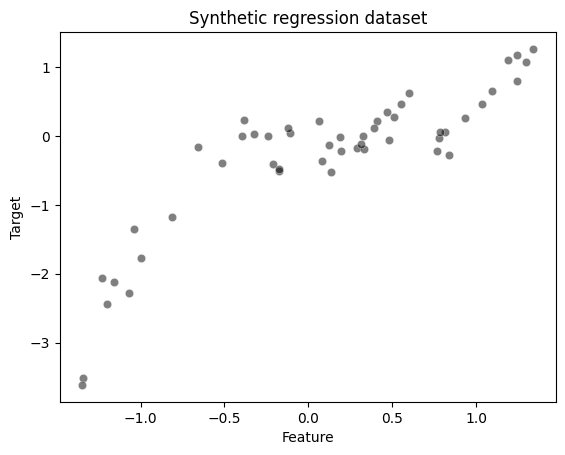

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(
    x=data_train["Feature"], y=target_train, color="black", alpha=0.5
)
_ = plt.title("Synthetic regression dataset")

In [4]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

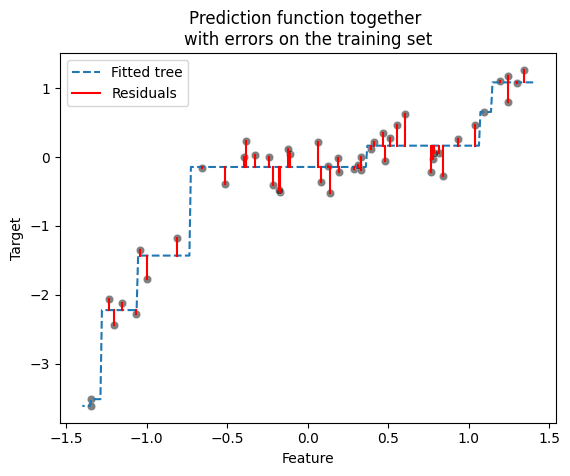

In [5]:
sns.scatterplot(
    x=data_train["Feature"], y= target_train, color="black", alpha=0.5
)

line_predictions = plt.plot(data_test["Feature"], target_test_predicted, "--")

for value, true, predicted in zip(
    data_train["Feature"], target_train, target_train_predicted
):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend(
    [line_predictions[0], lines_residuals[0]], ["Fitted tree", "Residuals"]
)#legend manually edited to get single label for all lines

_ = plt.title("Prediction function together \nwith errors on the training set")


In [6]:
#now train tree that can predict residuals
residuals = target_train - target_train_predicted

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train)
target_test_predicted_residuals = tree_residuals.predict(data_test)

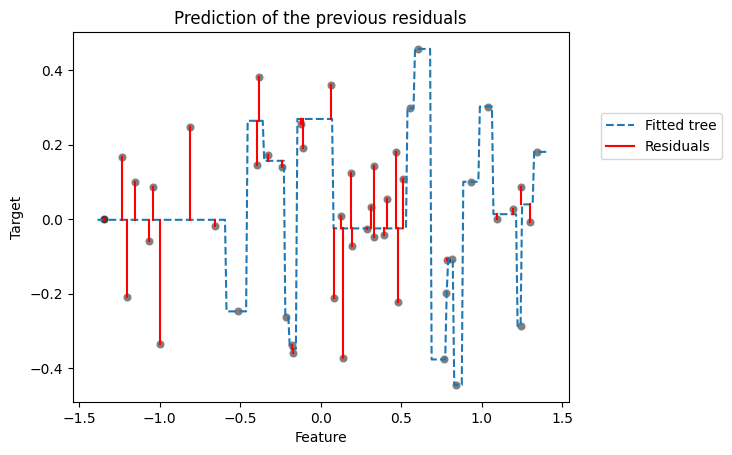

In [8]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(
    data_test["Feature"], target_test_predicted_residuals, "--"
)

for value, true, predicted in zip(
    data_train["Feature"], residuals, target_train_predicted_residuals
):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")
plt.legend(
    [line_predictions[0], lines_residuals[0]],
    ["Fitted tree", "Residuals"],
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left",
)
_ = plt.title("Prediction of the previous residuals")

In [9]:
sample = data_train.iloc[[-2]]
x_sample = sample["Feature"].iloc[0]
target_true = target_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

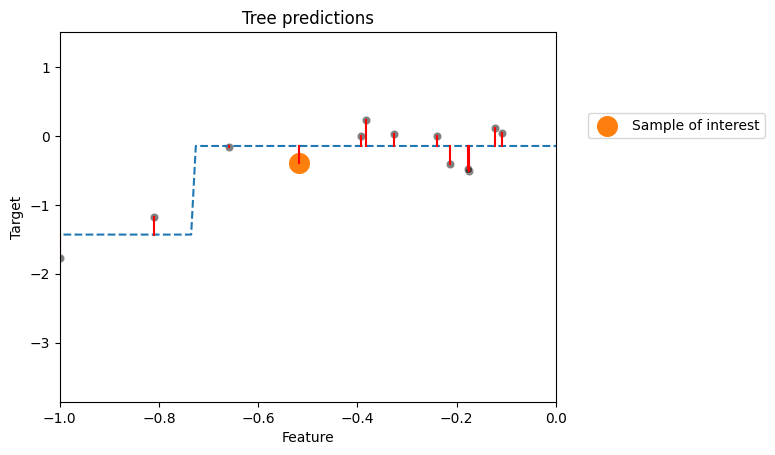

In [10]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black", alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted, "--")
for value, true, predicted in zip(
    data_train["Feature"], target_train, target_train_predicted
):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.scatter(sample, target_true, label="Sample of interest", color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Tree predictions")

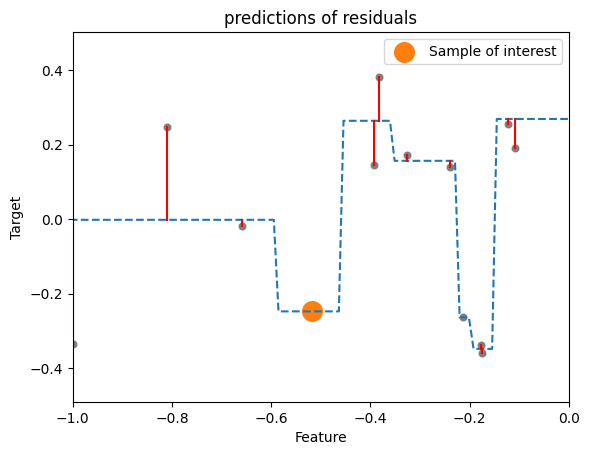

In [11]:
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
plt.plot(data_test["Feature"], target_test_predicted_residuals, "--")
for value, true, predicted in zip(
    data_train["Feature"], residuals, target_train_predicted_residuals
):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.scatter(sample, target_true_residual, label="Sample of interest", color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("predictions of residuals")


In [12]:
print(f"True value to predict for f(x={x_sample:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict(sample)[0]
print(
    f"Prediction of the first decision tree for x={x_sample:.3f}: "
    f"y={y_pred_first_tree:.3f}"
)
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.517) = -0.393
Prediction of the first decision tree for x=-0.517: y=-0.145
Error of the tree: -0.248


In [13]:
print(
    f"Prediction of the residual for x={x_sample:.3f}: "
    f"{tree_residuals.predict(sample)[0]:.3f}"
)

Prediction of the residual for x=-0.517: -0.248


In [14]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict(sample)[0]
)
print(
    "Prediction of the first and second decision tree combined for "
    f"x={x_sample:.3f}: y={y_pred_first_and_second_tree:.3f}"
)
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision tree combined for x=-0.517: y=-0.393
Error of the tree: 0.000


In [15]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error", n_jobs=2)


In [17]:
print("Gradient Boosting Decision Tree")
print(
    "Mean absolute error via cross-validation: "
    f"{-cv_results_gbdt['test_score'].mean():.3f} ± "
    f"{cv_results_gbdt['test_score'].std():.3f} k$"
)
print(f"Average fit time: {cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: {cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 46.386 ± 2.910 k$
Average fit time: 6.457 seconds
Average score time: 0.010 seconds


In [18]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=2)
cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error", n_jobs=2
)

In [19]:
print("Random Forest")
print(
    "Mean absolute error via cross-validation: "
    f"{-cv_results_rf['test_score'].mean():.3f} ± "
    f"{cv_results_rf['test_score'].std():.3f} k$"
)
print(f"Average fit time: {cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: {cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest
Mean absolute error via cross-validation: 46.671 ± 4.747 k$
Average fit time: 13.174 seconds
Average score time: 0.094 seconds
